In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Import MobileNetV2's preprocess_input

In [2]:
dataset = pd.read_csv('..\Dataset.csv')

In [3]:
dataset = dataset[dataset['year'] < 2024]

In [4]:
# Dropping gop_pct_avg and adjusted_gop_pct_bo_avg since they have high correlation with target
dataset = dataset.drop(columns=['gop_pct_avg', 'adjusted_gop_pct_bo_avg'])

In [5]:
# Adding noise to 'adjusted_gop_pct_estimate' to decouple from target and prevent data leakage

np.random.seed(42)

noise = np.random.normal(0, 0.1, dataset['adjusted_gop_pct_estimate'].shape)

dataset['adjusted_gop_pct_estimate'] = dataset['adjusted_gop_pct_estimate'] + noise

DATA-PREPARATION

In [6]:
training_data = dataset.drop(columns=['state_name', 'county_name', 'image_name', 'per_gop', 'per_dem'])
image_data = dataset[['year', 'fips', 'image_name']]
target_data = dataset[['per_gop']] # only taking per_gop since per_dem has negative correlation with per_gop

CORRELATION-ANALYSIS-WITH-TARGET

In [7]:
features_data = training_data.drop(columns=['year', 'fips'])

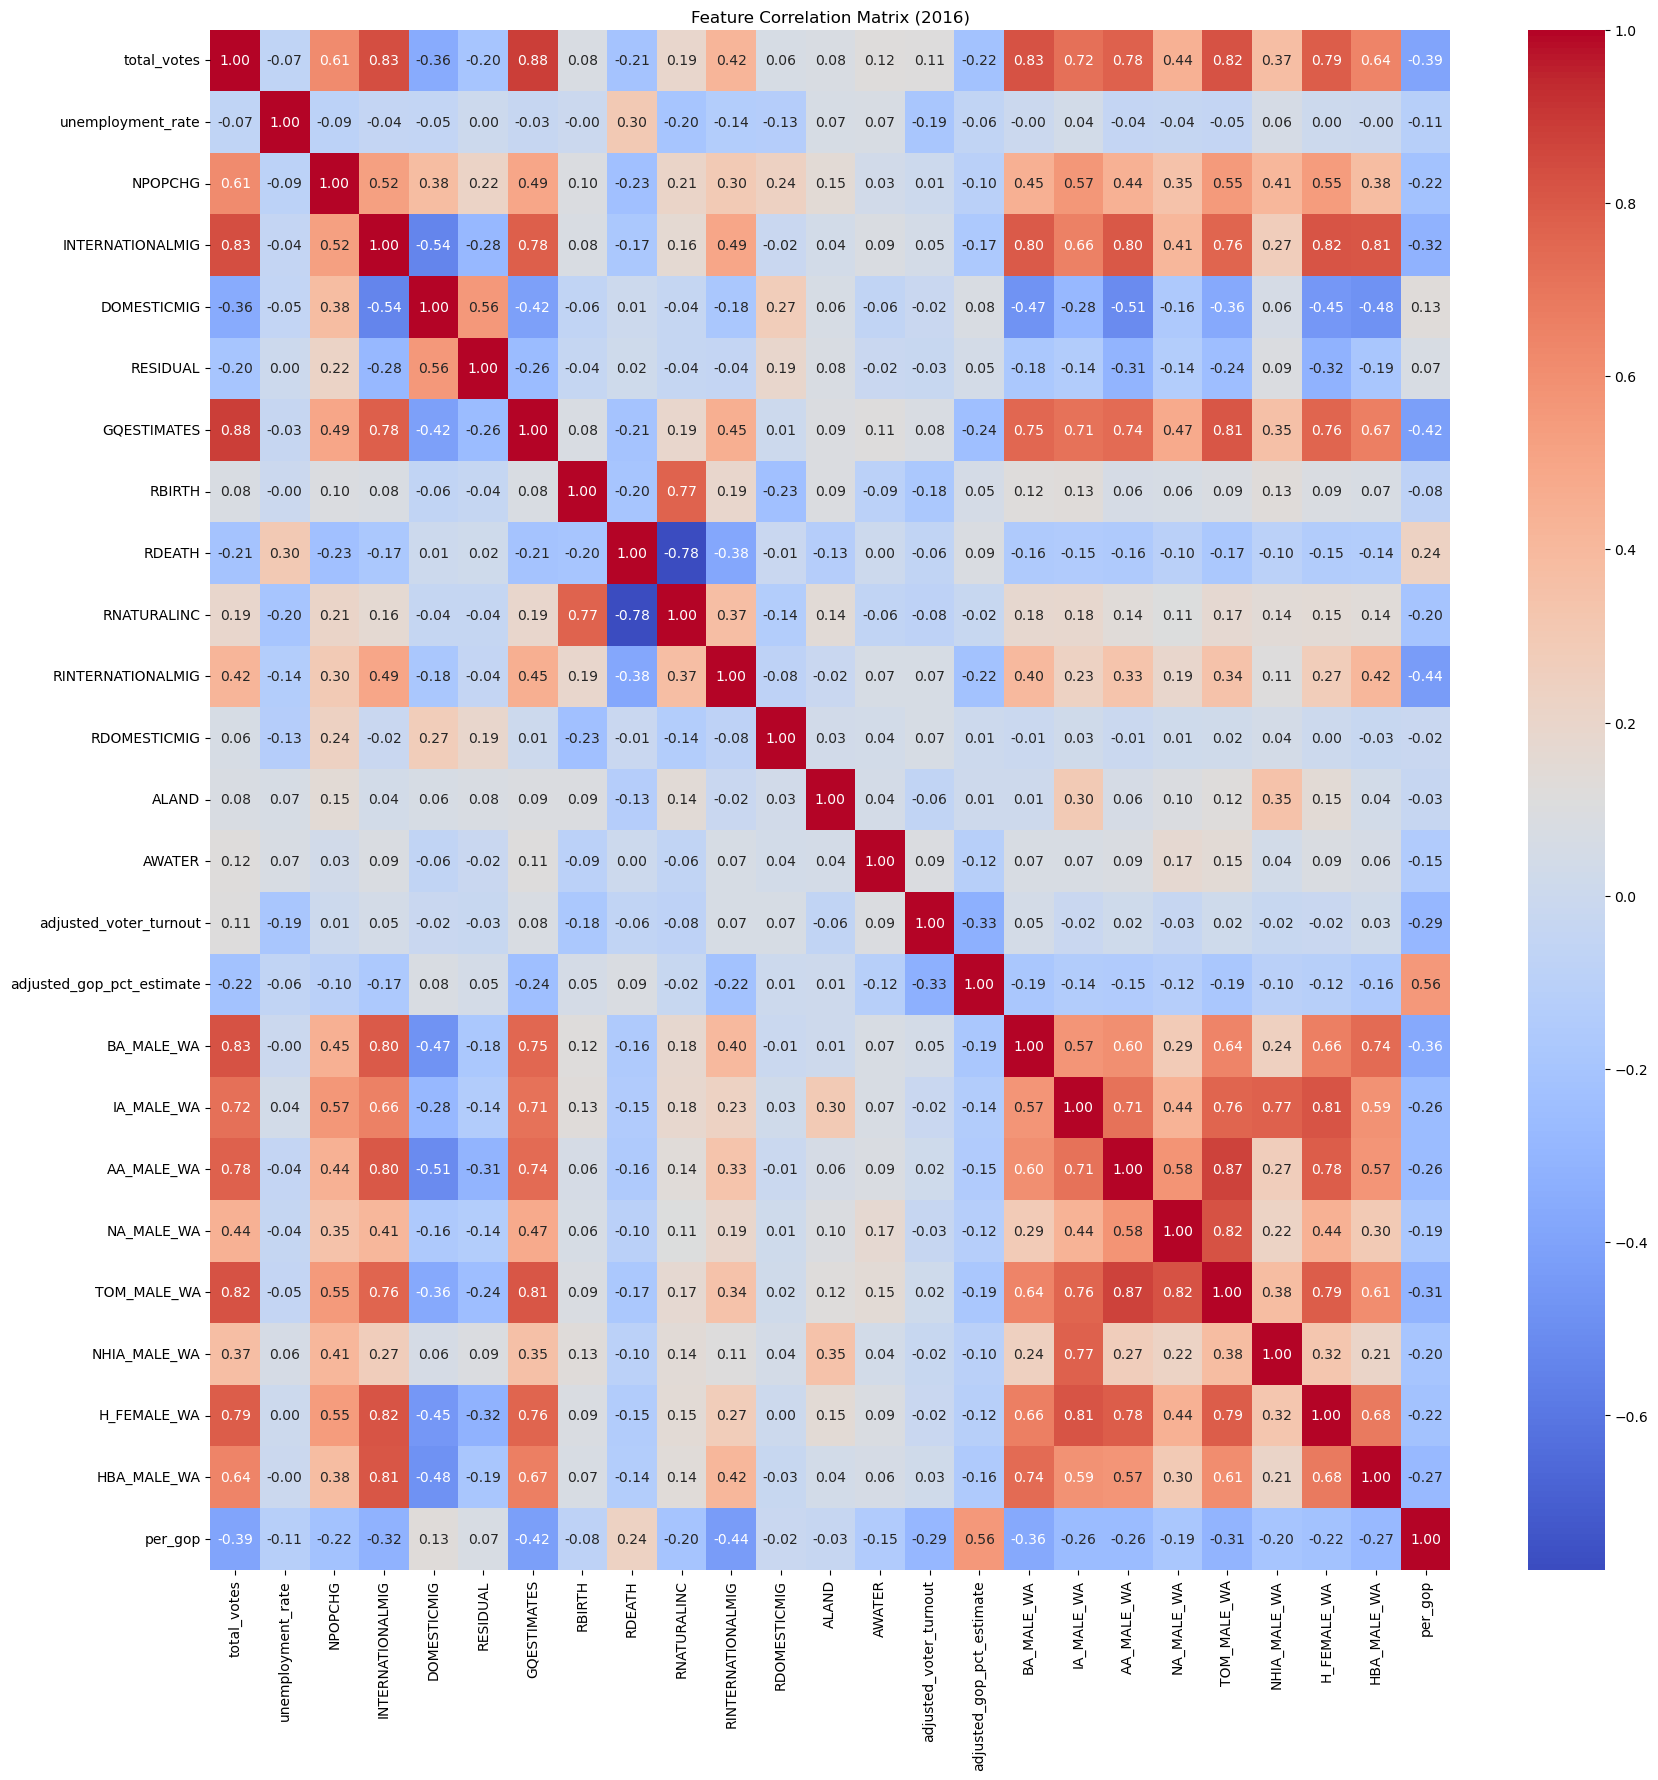

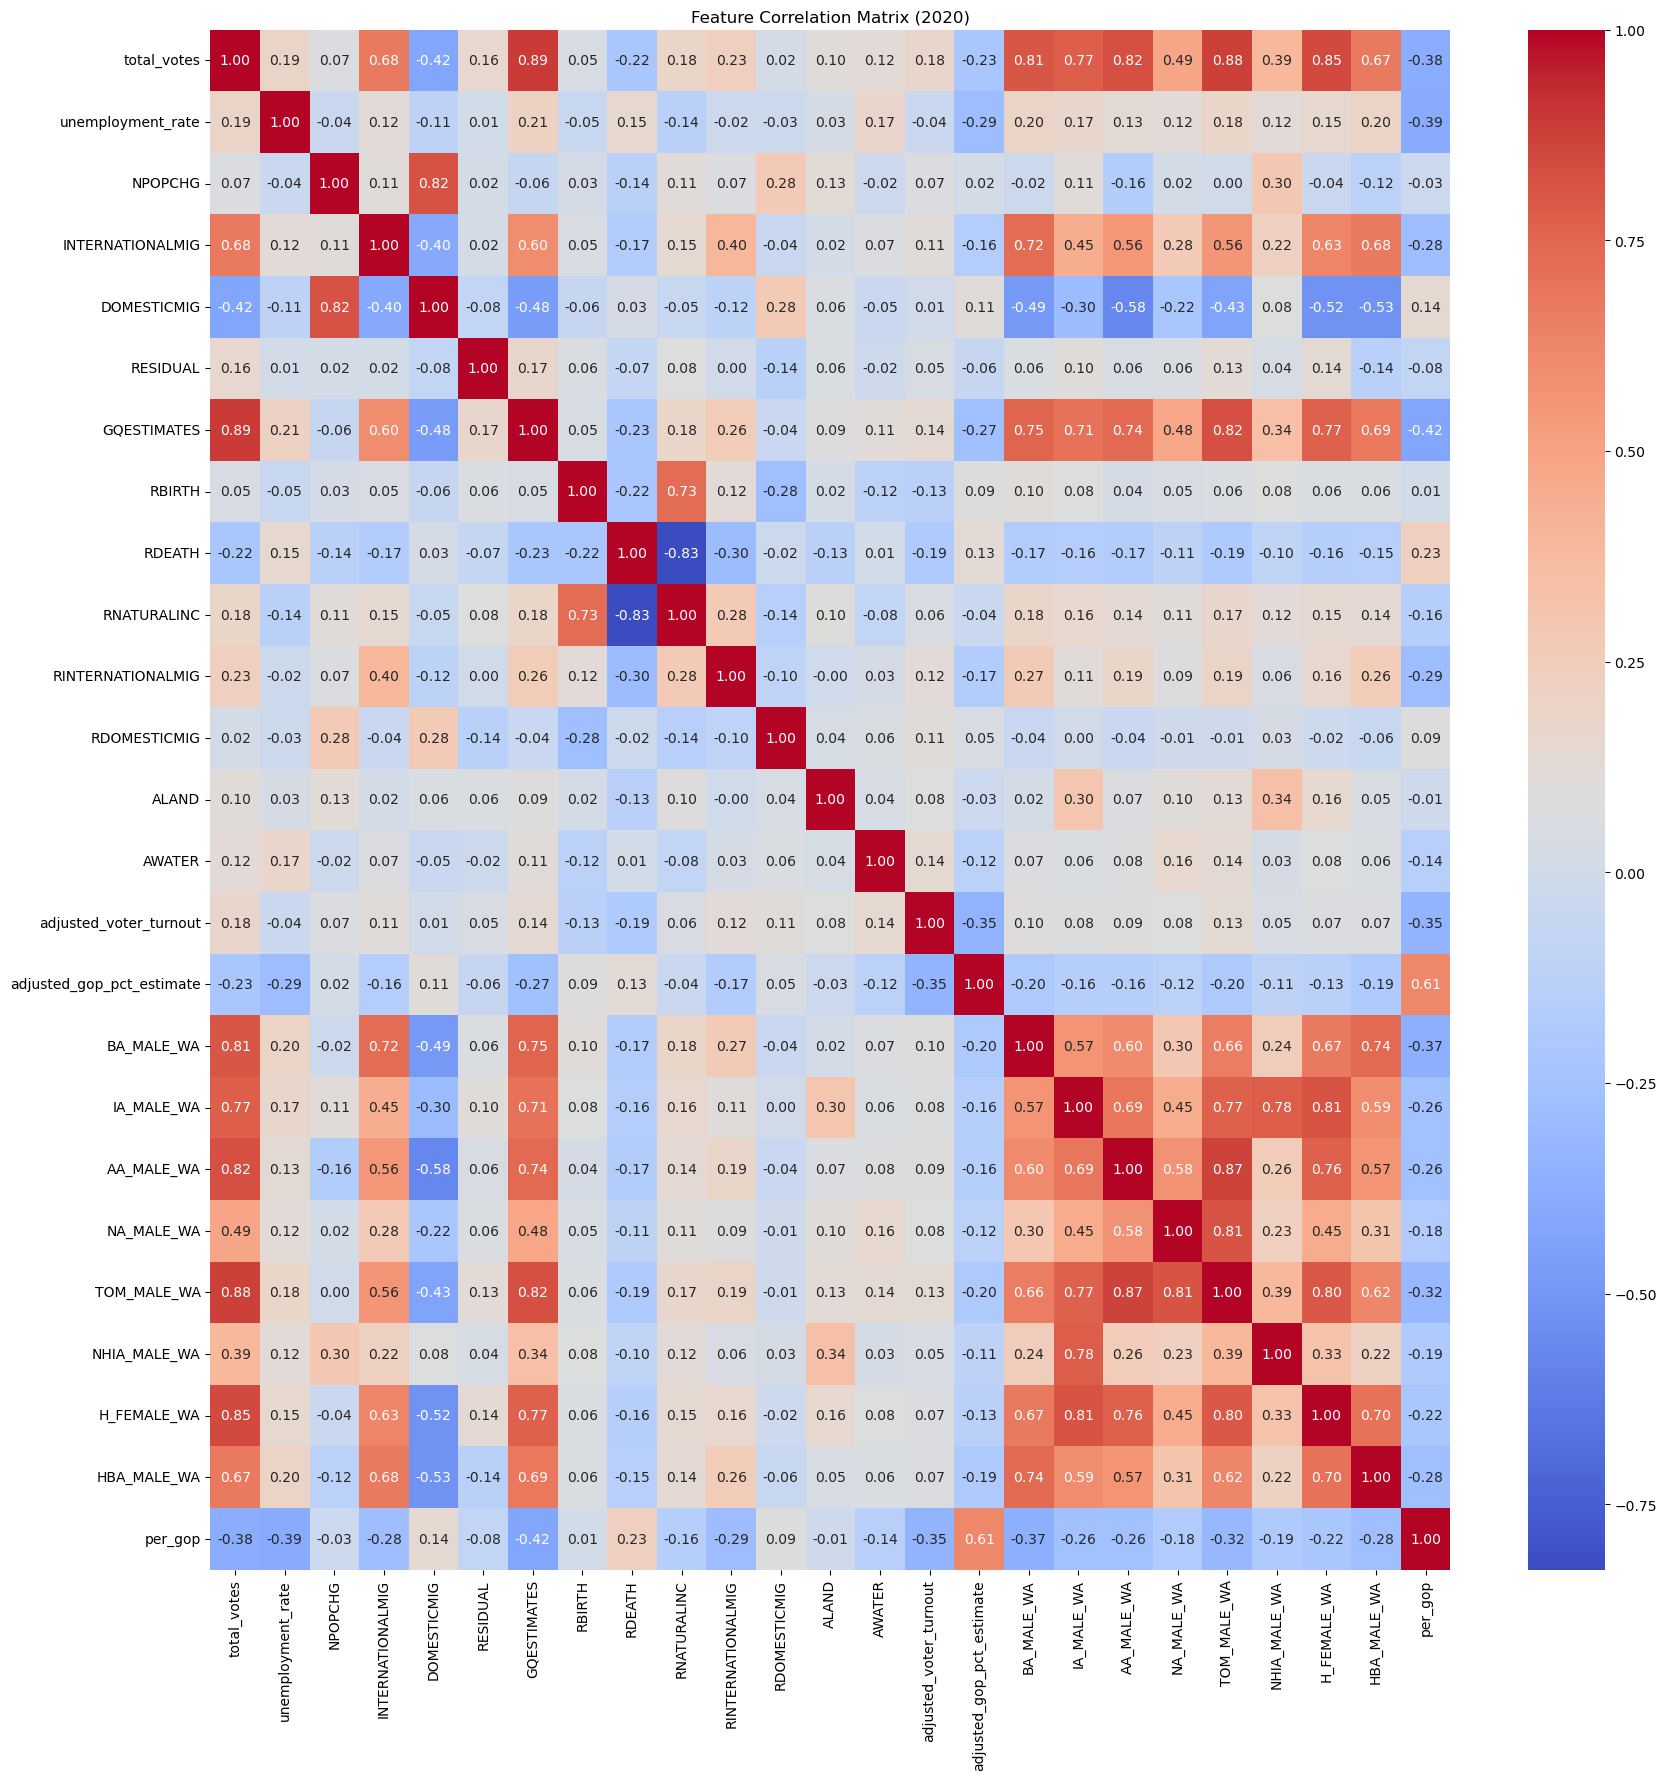

In [8]:
df = dataset[features_data.columns.tolist() + ['year', 'fips', 'per_gop']]

# Compute the correlation matrix for each year (2016 and 2020)
df_2016 = df[df['year'] == 2016]
df_2020 = df[df['year'] == 2020]

# Calculate correlation matrix for 2016
correlation_2016 = df_2016.drop(columns=['year', 'fips']).corr(numeric_only=True)
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_2016, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (2016)")
plt.show()

# Calculate correlation matrix for 2020
correlation_2020 = df_2020.drop(columns=['year', 'fips']).corr(numeric_only=True)
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_2020, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (2020)")
plt.show()

Feature-Fusion

In [9]:
# Separate features and target
X = training_data.copy()
y = target_data.squeeze()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the 'fips' column
X['fips'] = label_encoder.fit_transform(X['fips'])

# Optional: You can also apply label encoding for the 'year' column, if necessary
# Here, we use label encoding for year (if 'year' is categorical and has few values)
year_encoder = LabelEncoder()
X['year'] = year_encoder.fit_transform(X['year'])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Min-Max scaling to the continuous columns
columns_to_scale = [column for column in X.columns if column not in ['fips', 'year']]
scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [10]:
# Initialize empty lists for images and target values
image_list = []
target_values = []

# Loop through the rows of the DataFrame (assumes image_data and target_data are pandas DataFrames)
for (index, row), (index2, row2) in zip(image_data.iterrows(), target_data.iterrows()):
    year = str(row['year'])  # Convert to string to handle year folders
    image_name = row['image_name'] + '.jpg' 

    # Append target value to the list (per_gop is the target for regression)
    target_values.append(row2['per_gop'])

    # Define the folder path for the given year
    year_folder_path = os.path.join('..\satellite-images', f'{year}-US-Counties-Images-500k')

    # Check if the folder exists for the given year
    if os.path.exists(year_folder_path):
        image_path = os.path.join(year_folder_path, image_name)

        # Check if the image exists in the folder
        if os.path.exists(image_path):
            try:
                # Open the image using PIL and convert to a NumPy array
                img = Image.open(image_path).resize((224, 224))  # Resize to 224x224
                img_array = np.array(img)  # Convert image to numpy array

                # Preprocess the image
                img_array = preprocess_input(img_array)

                image_list.append(img_array)  # Add the image array to the list
            except Exception as e:
                print(f"Error opening {image_name}: {e}")
        else:
            print(f"Image {image_name} not found in {year_folder_path}")
    else:
        print(f"Folder for year {year} does not exist.")

# After the loop, image_list will contain all the images in NumPy format
print(f"Total data loaded: {len(image_list)}, {len(target_values)}")

Total data loaded: 6169, 6169


In [11]:
# Convert image_list and target_values to numpy arrays
X = np.array(image_list)  # Shape: (num_samples, 224, 224, 3)
y = np.array(target_values)  # Shape: (num_samples,)

In [12]:
X_train_images = X[X_train_scaled.index.to_numpy()]
X_val_images = X[X_test_scaled.index.to_numpy()]

y_train_images = y[X_train_scaled.index.to_numpy()]
y_val_images = y[X_test_scaled.index.to_numpy()]

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

tf.random.set_seed(42)

# Load MobileNetV2 pretrained model (without the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Use the output of the last convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from the preprocessed images
def extract_features(image_data):
    """
    Extract features from the preprocessed image data using MobileNetV2.
    Args:
    - image_data: Preprocessed image data (numpy array)
    
    Returns:
    - features: Flattened feature vectors for each image
    """
    # Extract features using the model
    features = model.predict(image_data, batch_size=32)
    
    # Use Global Average Pooling to get a fixed-length feature vector
    features = features.reshape(features.shape[0], -1)  # Flatten the features
    
    return features

# Extract features for training and validation sets
X_train_features = extract_features(X_train_images)
X_val_features = extract_features(X_val_images)

# Check the shape of the extracted features
print("X_train_features shape:", X_train_features.shape)
print("X_val_features shape:", X_val_features.shape)


39/39 [==============================] - 23s 582ms/step
X_train_features shape: (4935, 62720)
X_val_features shape: (1234, 62720)


In [14]:
from sklearn.decomposition import PCA

# Initialize PCA and choose the number of components
pca = PCA(n_components=20, random_state=42)  # Set the desired number of components

# Fit PCA to the training features and transform the training and validation data
X_train_reduced = pca.fit_transform(X_train_features)
X_val_reduced = pca.transform(X_val_features)

# Check the reduced shape
print("X_train_reduced shape:", X_train_reduced.shape)
print("X_val_reduced shape:", X_val_reduced.shape)


X_train_reduced shape: (4935, 20)
X_val_reduced shape: (1234, 20)


In [15]:
# Concatenate along columns (axis=1)
X_train_combined = np.concatenate((X_train_scaled, X_train_reduced), axis=1)
X_val_combined = np.concatenate((X_test_scaled, X_val_reduced), axis=1)

# Check the shapes of the concatenated arrays
print("X_train_combined shape:", X_train_combined.shape)  # Should be (4935, 46)
print("X_val_combined shape:", X_val_combined.shape)      # Should be (1234, 46)


X_train_combined shape: (4935, 46)
X_val_combined shape: (1234, 46)


Model-Development

In [ ]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [1.0, 0.8],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Manually iterate over hyperparameters and calculate R² on both training and test sets
best_r2_test = -np.inf  # Initialize with a very low value
smallest_gap = np.inf  # Initialize with a large value
best_params = None

for n_estimators in param_dist['n_estimators']:
    for learning_rate in param_dist['learning_rate']:
        for max_depth in param_dist['max_depth']:
            for min_samples_split in param_dist['min_samples_split']:
                for min_samples_leaf in param_dist['min_samples_leaf']:
                    for subsample in param_dist['subsample']:
                        for max_features in param_dist['max_features']:
                            
                            # Initialize the gbr with current hyperparameters
                            gbr = GradientBoostingRegressor(
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                subsample=subsample,
                                max_features=max_features,
                                random_state=42
                            )
                            
                            # Train the model
                            gbr.fit(X_train_combined, y_train)
                            
                            # Make predictions on the training and test set
                            y_train_pred = gbr.predict(X_train_combined)
                            y_test_pred = gbr.predict(X_val_combined)
                            
                            # Calculate R² on both the training and test set
                            r2_train = r2_score(y_train, y_train_pred)
                            r2_test = r2_score(y_test, y_test_pred)
                            
                            # Calculate the gap between training and test R²
                            gap = abs(r2_train - r2_test)
                            
                            # If this model has a higher test R² and a smaller gap, update the best parameters
                            if r2_test > 0.73 and gap < smallest_gap:
                                best_r2_test = r2_test
                                smallest_gap = gap
                                best_params = {
                                    'n_estimators': n_estimators,
                                    'learning_rate': learning_rate,
                                    'max_depth': max_depth,
                                    'min_samples_split': min_samples_split,
                                    'min_samples_leaf': min_samples_leaf,
                                    'subsample': subsample,
                                    'max_features': max_features
                                }

# Output the best hyperparameters, test R², and gap
print("Best hyperparameters found: ", best_params)
print("Best R² on test set: ", best_r2_test)
print("Smallest gap between training and testing R²: ", smallest_gap)


Best hyperparameters found:  {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.8, 'max_features': 'sqrt'}
Best R² on test set:  0.7558380788331376
Smallest gap between training and testing R²:  0.1199658492365201


In [41]:
# Initialize and train Gradient Boosting Regressor
#gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=2, subsample=0.8, max_features='sqrt')
gbr.fit(X_train_combined, y_train)

# Make predictions
y_pred_train = gbr.predict(X_train_combined)
y_pred_test = gbr.predict(X_val_combined)

Model-Performance

In [42]:
# Evaluate the model
mse_train = mean_squared_error(y_train_images, y_pred_train)
r2_train = r2_score(y_train_images, y_pred_train)
mse_test = mean_squared_error(y_val_images, y_pred_test)
r2_test = r2_score(y_val_images, y_pred_test)

print(f"Mean Squared Error Training: {mse_train}")
print(f"R-squared Training: {r2_train}")
print(f"Mean Squared Error Testing: {mse_test}")
print(f"R-squared Testing: {r2_test}")

Mean Squared Error Training: 0.003131963587263272
R-squared Training: 0.8758039280696577
Mean Squared Error Testing: 0.006161844790023549
R-squared Testing: 0.7558380788331376


In [43]:
y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

per_dem_train = [1 - y_train for y_train in y_train_images]
per_dem_pred_train = [1 - y_pred for y_pred in y_pred_train]

per_dem_test = [1 - y_test for y_test in y_val_images]
per_dem_pred_test = [1 - y_pred for y_pred in y_pred_test]

In [44]:
# Evaluate the model
mse_train = mean_squared_error(per_dem_train, per_dem_pred_train)
mse_test = mean_squared_error(per_dem_test, per_dem_pred_test)

print(f"Mean Squared Error Training: {mse_train}")
print(f"Mean Squared Error Testing: {mse_test}")

Mean Squared Error Training: 0.003131963587263272
Mean Squared Error Testing: 0.006161844790023549


In [45]:
threshold = 0.5

party_won_actual_train = [1 if actual > threshold else 0 for actual in y_train_images]
party_won_pred_train = [1 if pred > threshold else 0 for pred in y_pred_train]

party_won_actual_test = [1 if actual > threshold else 0 for actual in y_val_images]
party_won_pred_test = [1 if pred > threshold else 0 for pred in y_pred_test]

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics using sklearn functions
accuracy = accuracy_score(party_won_actual_train, party_won_pred_train)
precision = precision_score(party_won_actual_train, party_won_pred_train)
recall = recall_score(party_won_actual_train, party_won_pred_train)
f1 = f1_score(party_won_actual_train, party_won_pred_train)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.94
Precision: 0.94
Recall: 0.99
F1 Score: 0.96


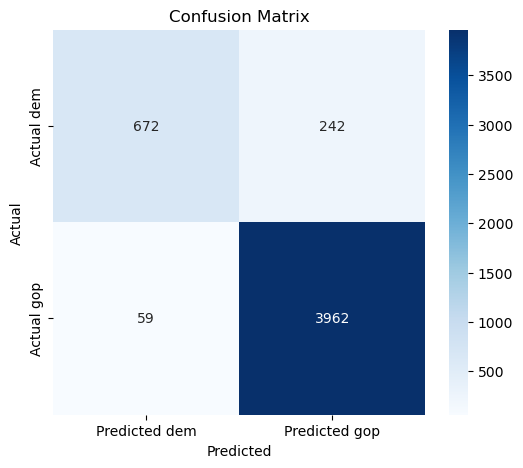

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(party_won_actual_train, party_won_pred_train)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted dem', 'Predicted gop'], yticklabels=['Actual dem', 'Actual gop'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics using sklearn functions
accuracy = accuracy_score(party_won_actual_test, party_won_pred_test)
precision = precision_score(party_won_actual_test, party_won_pred_test)
recall = recall_score(party_won_actual_test, party_won_pred_test)
f1 = f1_score(party_won_actual_test, party_won_pred_test)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.92
Precision: 0.93
Recall: 0.97
F1 Score: 0.95


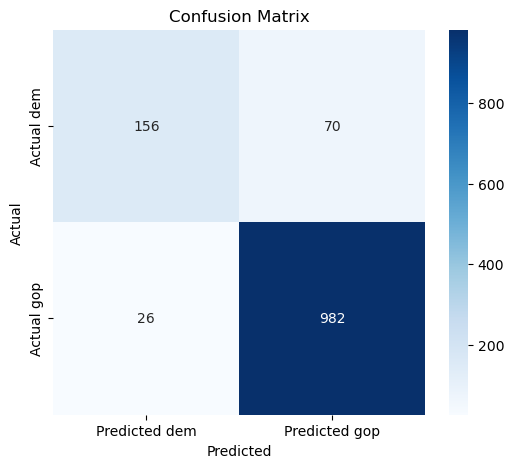

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(party_won_actual_test, party_won_pred_test)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted dem', 'Predicted gop'], yticklabels=['Actual dem', 'Actual gop'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

2024-Performance

In [50]:
dataset_2024 = dataset = pd.read_csv('..\Dataset.csv')
dataset_2024 = dataset[dataset['year'] == 2024]

In [51]:
training_data_2024 = dataset_2024.drop(columns=['state_name', 'county_name', 'image_name', 'per_gop', 'per_dem', 'gop_pct_avg', 'adjusted_gop_pct_bo_avg'])
image_data_2024 = dataset_2024[['year', 'fips', 'image_name']]
target_data_2024 = dataset_2024[['per_gop']]

In [52]:
# Initialize empty lists for images and target values
image_list = []
target_values = []

# Loop through the rows of the DataFrame (assumes image_data and target_data are pandas DataFrames)
for (index, row), (index2, row2) in zip(image_data_2024.iterrows(), target_data_2024.iterrows()):
    year = str(row['year'])  # Convert to string to handle year folders
    year = '2023' if year == '2024' else year
    image_name = row['image_name'] + '.jpg'  # Assuming images are jpg (adjust as needed)

    # Append target value to the list (per_gop is the target for regression)
    target_values.append(row2['per_gop'])

    # Define the folder path for the given year
    year_folder_path = os.path.join('../satellite-images', f'{year}-US-Counties-Images-500k')

    # Check if the folder exists for the given year
    if os.path.exists(year_folder_path):
        image_path = os.path.join(year_folder_path, image_name)

        # Check if the image exists in the folder
        if os.path.exists(image_path):
            try:
                # Open the image using PIL and convert to a NumPy array
                img = Image.open(image_path).resize((224, 224))  # Resize to 224x224
                img_array = np.array(img)  # Convert image to numpy array

                # Preprocess the image
                img_array = preprocess_input(img_array)

                image_list.append(img_array)  # Add the image array to the list
            except Exception as e:
                print(f"Error opening {image_name}: {e}")
        else:
            print(f"Image {image_name} not found in {year_folder_path}")
    else:
        print(f"Folder for year {year} does not exist.")

# After the loop, image_list will contain all the images in NumPy format
print(f"Total data loaded: {len(image_list)}, {len(target_values)}")

Total data loaded: 3076, 3076


In [53]:
# Convert image_list and target_values to NumPy arrays
X_2024_images = np.array(image_list)  # Shape: (num_samples, 224, 224, 3)
y_2024_images = np.array(target_values)  # Shape: (num_samples,)

In [54]:
# Extract features for training and validation sets
X_features_2024 = extract_features(X_2024_images)

# Check the shape of the extracted features
print("X_train_features shape:", X_features_2024.shape)

97/97 [==============================] - 59s 587ms/step
X_train_features shape: (3076, 62720)


In [55]:
# Fit PCA to the training features and transform the training and validation data
X_2024_features_reduced = pca.transform(X_features_2024)

# Check the reduced shape
print("X_2024_features_reduced shape:", X_2024_features_reduced.shape)

X_2024_features_reduced shape: (3076, 20)


In [56]:
# Separate features and target
X_2024_scaled = training_data_2024.copy()
#X = X[['year', 'fips'] + features_data.columns.tolist()]
y = target_data_2024.squeeze()

columns_to_scale = [column_name for column_name in X_2024_scaled.columns.tolist() if column_name not in ['year', 'fips']]


X_2024_scaled[columns_to_scale] = scaler.transform(X_2024_scaled[columns_to_scale])

X_2024_scaled['year'] = 2
X_2024_scaled['fips'] = label_encoder.transform(X_2024_scaled['fips'])

In [57]:
# Concatenate along columns (axis=1)
X_combined_2024 = np.concatenate((X_2024_scaled, X_2024_features_reduced), axis=1)

# Check the shapes of the concatenated arrays
print("X_train_combined shape:", X_combined_2024.shape) 

X_train_combined shape: (3076, 46)


In [58]:
# Make predictions
y_pred = gbr.predict(X_combined_2024)

# Evaluate the model
mse = mean_squared_error(y_2024_images, y_pred)
r2 = r2_score(y_2024_images, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.005951275119560134
R-squared: 0.7582626898630178


In [59]:
per_dem = [1 - y_a for y_a in y_2024_images]
per_dem_pred = [1 - y_p for y_p in y_pred.flatten()]

In [60]:
# Evaluate the model
mse = mean_squared_error(per_dem, per_dem_pred)

print("Mean Squared Error:",mse)

Mean Squared Error: 0.005951275119560136


In [61]:
threshold = 0.5

party_won_actual = [1 if actual > threshold else 0 for actual in y_2024_images]
party_won_pred = [1 if pred > threshold else 0 for pred in y_pred.flatten()]

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics using sklearn functions
accuracy = accuracy_score(party_won_actual, party_won_pred)
precision = precision_score(party_won_actual, party_won_pred)
recall = recall_score(party_won_actual, party_won_pred)
f1 = f1_score(party_won_actual, party_won_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.92
Precision: 0.94
Recall: 0.97
F1 Score: 0.96


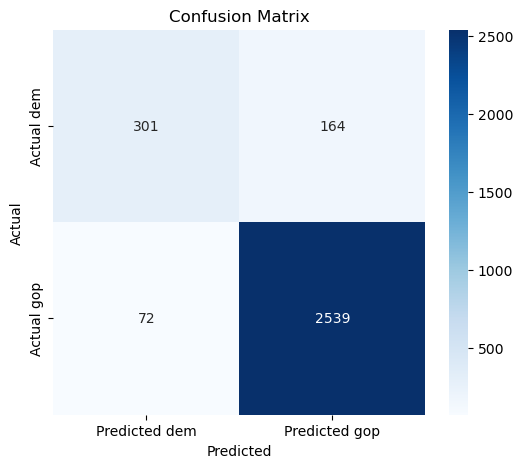

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(party_won_actual, party_won_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted dem', 'Predicted gop'], yticklabels=['Actual dem', 'Actual gop'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()